#Predicting Airline Delays

<img src='Delays.jpg', width = 800, height = 600>
[Source](http://mashable.com/2014/10/09/airline-delays-increase/)

I don't know about all of you, but flying doesn't always go smoothly for me. I have had some horror stories I could tell you about weird delays I have encountered while flying. Wouldn't it be nice to know how much your flight will probably be delayed and why?

Well, that's what this project will attempt to do. Granted, the data scientists over at Hortonworks [did a very similar project](http://hortonworks.com/blog/data-science-apacheh-hadoop-predicting-airline-delays/) (and a well done one in my opinion!) just a few months ago. My project will be a little different from theirs in that instead of doing a classification problem (yes/no for a delayed flight), this will be a regression problem where I will try to predict the delay time in number of minutes (which can be negative). The regression model will not be restricted to a single city, so we are going to be working with a very large number of training examples! 

To complete this project, we need some data about flights. Fortunately, the government keeps such a resource available that we are going to examine in this project. 

Similar to the project about faculty salaries, this notebook will be split into two major parts: exploratory data analysis and feature engineering in R, with regression model implementation in Python. 

##Getting the Data

For this project, the best place to get data about airlines is from the US Department of Transportation, [here](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236). There are several options available for what data you can choose and which features. For this project, I chose the following features:

- Year
- Month
- DayofMonth
- DayofWeek
- UniqueCarrier
- OriginAirportID
- DestAirportID
- CRSDepTime (the local time the plane was scheduled to depart)
- CRSArrTime (the local time the plane was scheduled to arrive)
- ArrDelay (how early/late the plane was at its final destination in minutes: our target variable)
- Distance (how far did the plane travel for the route)
- CRSElapsedTime (the scheduled difference between departure and arrival)

I only wished to include features that a user could enter at any time. In theory, you could predict your flight delay for 6 months from now with this model. Because of that, I can't include any time dependent features (such as, sadly for me, weather, which could have helped with this model's accuracy). The Hortonworks example included weather data as an interesting augmentation to the model. However, for the way I want to set up this model, including weather data would be an example of [data leakage](http://www.quora.com/Whats-data-leakage-in-data-science). 

As someone who has studied the weather for a very long time, trust me when I say the furthest out you can predict the weather at a specific location with any sort of accuracy is about a week. We can't include daily max wind speeds, snowfall totals, etc. because there is no way of knowing that before you fly and the day has already ended!

Unfortunately, the way the Department of Transportation processes the downloading, you have to select which features you want and download them, but only for one month at a time (which is tedious and takes a while). Because of this, I have collated the data for you in one large file available on AWS (Amazon Web Services) S3 so you don't have to deal with any of this! The data I chose is for a full year extending from November 2013 to October 2014 (when I did the programming for this project, not all of 2014 was available yet). I have also included a lookup table for the Airports and Carriers that will become useful later. 

Now that we understand the basics of the data, let's get it loaded into R (**warning**: the collated file is about 350 MB so downloading it may take a little while if you are following along!)

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
airportsDB <- read.csv('http://s3.amazonaws.com/jsw.dsprojects/AirlinePredictions/Airport_Lookup.csv',
                      header = TRUE, stringsAsFactors = FALSE)
carriersDB <- read.csv('http://s3.amazonaws.com/jsw.dsprojects/AirlinePredictions/Carrier_Lookup.csv',
                       header = TRUE, stringsAsFactors = FALSE)
flightsDB <- read.csv('http://s3.amazonaws.com/jsw.dsprojects/AirlinePredictions/CombinedFlights.csv',
                        header = TRUE, stringsAsFactors = FALSE)

Let's take a look at what our flightsDB dataframe contains to make sure there weren't any issues.

In [4]:
%%R

head(flightsDB)

  X.1 YEAR MONTH DAY_OF_MONTH DAY_OF_WEEK UNIQUE_CARRIER ORIGIN_AIRPORT_ID
1   1 2014     1            1           3             AA             12478
2   2 2014     1            2           4             AA             12478
3   3 2014     1            3           5             AA             12478
4   4 2014     1            4           6             AA             12478
5   5 2014     1            5           7             AA             12478
6   6 2014     1            6           1             AA             12478
  DEST_AIRPORT_ID CRS_DEP_TIME CRS_ARR_TIME ARR_DELAY CRS_ELAPSED_TIME DISTANCE
1           12892          900         1225        13              385     2475
2           12892          900         1225         1              385     2475
3           12892          900         1225        NA              385     2475
4           12892          900         1225        59              385     2475
5           12892          900         1225       110              385     

Looks like we can get rid of the first and last columns. We also don't need the YEAR column either.

In [5]:
%%R

flightsDB <- subset(flightsDB, select = -c(X, YEAR, X.1))

It also appeared as if some of the ARR_DELAY values are NA. We can't predict on these, and we have plenty of training examples anyway, so let's drop the rows where our target variable is missing. How many are missing?

In [6]:
%%R

summary(flightsDB$ARR_DELAY)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-112.00  -11.00   -3.00    7.48   11.00 1983.00  150482 


Well 150,000 missing rows does seem like a lot. How many flights are we dealing with?

In [7]:
%%R

dim(flightsDB)

[1] 5900609      11


We have 5.9 **MILLION** rows! Compared to that magnitude, 150,000 missing rows is a small percentage. There isn't much we can do with these missing values, so we need to drop them. Let's clean them out.

In [8]:
%%R

flightsDB <- na.omit(flightsDB)

Checking again just to make sure no other features have NA values . . .

In [9]:
%%R

summary(flightsDB)

     MONTH         DAY_OF_MONTH    DAY_OF_WEEK    UNIQUE_CARRIER    
 Min.   : 1.000   Min.   : 1.00   Min.   :1.000   Length:5750127    
 1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.:2.000   Class :character  
 Median : 7.000   Median :16.00   Median :4.000   Mode  :character  
 Mean   : 6.624   Mean   :15.74   Mean   :3.938                     
 3rd Qu.:10.000   3rd Qu.:23.00   3rd Qu.:6.000                     
 Max.   :12.000   Max.   :31.00   Max.   :7.000                     
 ORIGIN_AIRPORT_ID DEST_AIRPORT_ID  CRS_DEP_TIME   CRS_ARR_TIME 
 Min.   :10135     Min.   :10135   Min.   :   1   Min.   :   1  
 1st Qu.:11292     1st Qu.:11292   1st Qu.: 925   1st Qu.:1119  
 Median :12889     Median :12889   Median :1320   Median :1520  
 Mean   :12671     Mean   :12672   Mean   :1325   Mean   :1499  
 3rd Qu.:13931     3rd Qu.:13931   3rd Qu.:1720   3rd Qu.:1910  
 Max.   :16218     Max.   :16218   Max.   :2359   Max.   :2359  
   ARR_DELAY        CRS_ELAPSED_TIME    DISTANCE   
 Min.   :-

Looks like we are okay for missing values. Now that we have loaded our data and cleaned it a little bit, let's do some feature engineering.

##Creating a New Feature: Number of Days to Holiday

This feature was actually included in the Hortonworks example I linked to previously, and I thought it was a good idea. It makes intuitive sense that airlines are probably going to be under stress near holidays, so this feature could probably be a decent predictor of a late flight. 

First, we need all of the exact dates for holidays inside our range of flights (November 2013-October 2014). I had to look several of them up because they change every year (like Thanksgiving for example). Let's create a list of holiday dates and convert them to the DATE type in R.

In [10]:
%%R

holidays <- c('2014-01-01', '2014-01-20', '2014-02-17', '2014-05-26',
              '2014-07-04', '2014-09-01', '2014-10-13', '2013-11-11',
              '2013-11-28', '2013-12-25') # Ten major holidays, including Memorial Day, Columbus Day, Labor Day, MLK Day
                                          # Veteran's Day, New Year's, President's Day, Independence Day, Thanksgiving, 
                                          # and Christmas Day.
holidayDates <- as.Date(holidays)

To make things easier, let's create a function to calculate the difference between each of our flight dates and the nearest holiday. We got rid of the YEAR feature earlier as we don't need it for prediction or analysis, but we will need to include a provision for it in our function to find the exact number of days between any given date and a holiday.

In [11]:
%%R

DaysToHoliday <- function(month, day){ # Input a month and day from the flightsDB
  
  # Get our year.
  year <- 2014
  if (month > 10){
    year <- 2013
  }
  # Paste on a 2013 for November and December dates.
  
  currDate <- as.Date(paste(year,month,day,sep = '-')) # Create a DATE object we can use to calculate the time difference
  
  
  numDays <- as.numeric(min(abs(currDate-holidayDates))) # Now find the minimum difference between the date and our holidays
  return(numDays)                                        # We can vectorize this to automatically find the minimum closest
                                                         # holiday by subtracting all holidays at once
  
}


We **COULD** run this function on every one of our 5.9 million rows, but that would probably be quite slow. If were working on a cluster like in the Hortonworks example, you could probably get away with using Pig like they did to do it.

What would be a much faster and more creative way to solve this problem (since we are not using HDFS or a cluster here) is to create a lookup table that we can access instead. There are only 365 different days in the year, so we actually only need to run the function 365 times instead of 5.9 million. Then, save the results in a table we use later. Much better idea! This trick is often used in programming, and it is called [hashing](http://en.wikipedia.org/wiki/Hash_function) to speed up a program if a lot of the computation is redundant. 

So, let's create our own hash table to speed things up by quite a bit.

In [12]:
%%R

datesOfYear <- unique(flightsDB[,1:2]) # Get all of the dates through unique Month/Day combinations
datesOfYear$HDAYS <- mapply(DaysToHoliday, datesOfYear$MONTH, datesOfYear$DAY_OF_MONTH) 

# Apply our function in a vectorized manner via one of R's many "apply" functions (in this case mapply)
# to each unique date and save                                        

Let's take a look at our hash table to see that it worked.

In [13]:
%%R

head(datesOfYear)

  MONTH DAY_OF_MONTH HDAYS
1     1            1     0
2     1            2     1
4     1            4     3
5     1            5     4
6     1            6     5
7     1            7     6


Similar to before, we want to create a small function that we can then vectorize using mapply. Let's create a function to read from our hash table.

In [14]:
%%R

InputDays <- function(month,day){
  finalDays <- datesOfYear$HDAYS[datesOfYear$MONTH == month & datesOfYear$DAY_OF_MONTH == day] # Find which row to get
  return(finalDays)
}

Now let's run this much simpler lookup on all of our rows and generate the feature. If you are using this interactively, it will probably take 5-10 minutes, depending on your computer performance.

In [15]:
%%R

flightsDB$HDAYS <- mapply(InputDays, flightsDB$MONTH, flightsDB$DAY_OF_MONTH)

Let's check our new feature quickly.

In [16]:
%%R

head(flightsDB)

  MONTH DAY_OF_MONTH DAY_OF_WEEK UNIQUE_CARRIER ORIGIN_AIRPORT_ID
1     1            1           3             AA             12478
2     1            2           4             AA             12478
4     1            4           6             AA             12478
5     1            5           7             AA             12478
6     1            6           1             AA             12478
7     1            7           2             AA             12478
  DEST_AIRPORT_ID CRS_DEP_TIME CRS_ARR_TIME ARR_DELAY CRS_ELAPSED_TIME DISTANCE
1           12892          900         1225        13              385     2475
2           12892          900         1225         1              385     2475
4           12892          900         1225        59              385     2475
5           12892          900         1225       110              385     2475
6           12892          900         1225        -8              385     2475
7           12892          900         1225       -13     

To make things a little simpler, let's add two features that just bin the scheduled departure and arrival times by hour instead of to the nearest minute.

In [17]:
%%R

flightsDB$ARR_HOUR <- trunc(flightsDB$CRS_ARR_TIME/100) # Cuts off the minutes, essentially.
flightsDB$DEP_HOUR <- trunc(flightsDB$CRS_DEP_TIME/100)

Now that our feature engineering is finished, let's do some EDA (exploratory data analysis). 

##Exploratory Data Analysis

For this section, we are going to use the more recent library [dplyr](http://cran.rstudio.com/web/packages/dplyr/vignettes/introduction.html), which comes from Dr. Hadley Wickham's great collection of R libraries and was just released last year in early 2014 for the first time. It's an upgrade from the older plyr in several ways. Using dplyr with ggplot2 makes this part of data science, at least in my opinion, even faster and easier than ever before.

Let's load it in and create a couple of helper functions for our data exploration.

In [18]:
%%R

library(dplyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



To make the data visualization truly interactive and easy to use, we will need some utility functions. The first function we will make is a function that will allow us to call a specific airport by city name. If you look at the dataframe shown earlier, all of the airports aren't stored with their full name. Instead they use a unique ID that identifies the airport.

Remember that lookup table we downloaded at the very beginning? Now we need it. Let's take a quick look at it.

In [21]:
%%R

head(airportsDB)

   Code                                   Description
1 10001        Afognak Lake, AK: Afognak Lake Airport
2 10003 Granite Mountain, AK: Bear Creek Mining Strip
3 10004                      Lik, AK: Lik Mining Camp
4 10005        Little Squaw, AK: Little Squaw Airport
5 10006                    Kizhuyak, AK: Kizhuyak Bay
6 10007            Klawock, AK: Klawock Seaplane Base


It would be nice if we could investigate the data regarding a specific route. However, knowing the code requires referencing this table. There are also many airports in each city, but most likely we are just going to want the code for the largest, most frequently traveled airport. For example, let's look at a list of airports if we were to search the city of Chicago.

In [22]:
%%R

subset(airportsDB, grepl('Chicago', Description))

      Code                                  Description
943  10977                     Chicago, IL: Meigs Field
952  10986       Chicago, IL: Chicago Metropolitan Area
1322 11376                  Chicago, IL: Du Page County
1975 12055         Gary, IN: Gary/Chicago International
2216 12306     Chicago/Romeoville, IL: Lewis University
3099 13232    Chicago, IL: Chicago Midway International
3771 13930    Chicago, IL: Chicago O'Hare International
4152 14320               Chicago, IL: Chicago Executive
4296 14512 Rockford, IL: Chicago/Rockford International


See what I mean? If we search Chicago, most likely we are just going to want to look at O'Hare which is the largest airport in Chicago. We probably aren't interested in Megis Field or Du Page County airport. So, let's create a function that will figure out which airport we **meant** to look up by figuring out which airport comes up in the dataframe most frequently.

We will use two functions that will work together to do this (so we can use one of the "apply" functions from R). The first function will check each code entered and return the number of flights with this airport code.

In [19]:
%%R

MaxFlightsCode <- function(code){
  # Calculates the most likely flights based on flight frequency.
  codeFrame <- subset(flightsDB, ORIGIN_AIRPORT_ID == code)
  numFlights <- dim(codeFrame)[1]
  # Get the number of rows in this frame
  return(numFlights)
}

Our second function will allow us to enter a city (or city/state) of our choosing. The function will then find the airports matching our city, figure out which of those airports has the greatest number of flights (via calling our MaxFlightsCode function) and applying it via sapply to all of the codes in a vectorized manner.

In [23]:
%%R

AirportCode <- function(city){
  codes <- subset(airportsDB, grepl(city, Description))
  # Find all of the airports matching the city we entered
  codes$NumFlights <- sapply(codes$Code, MaxFlightsCode)
  # Collect how many flights exist in the database starting at this airport
  codes <- subset(codes, NumFlights == max(NumFlights))$Code
  # Return our top airport
  return(codes)
}

Let's try it out on Chicago and see if we get O'Hare (which is code 13930 from the subset we looked at earlier). 

In [24]:
%%R

AirportCode('Chicago')

[1] 13930


Now that we have this working, it should be a lot easier to find the airport codes we want. If you wanted a more specific airport (such as Midway), you could also type that and the function will figure it out.

Next, let's set up one robust plotting function that will allow us to combine dplyr with ggplot2 to see bar charts that examine the average arrival delay time for any feature we wish (such as by month, carrier, day of week, etc.). To do that, we will need to create another pair of functions. The first is an automated dplyr function that will group our mean delay time based on any feature we specify.

In [25]:
%%R

GrouperFunc <- function(df, ...) df %>% regroup(list(...))

Now we need to load in ggplot2 (since it hasn't been loaded yet).

In [26]:
%%R

library(ggplot2)

Use suppressPackageStartupMessages to eliminate package startup messages.


Finally, we will create our plotting function that will automatically make a bar chart showing us the mean delay time for any route based on any of our features! It's just one function, but it will be very versatile. To use it, we will be inputting the departure and arrival cities, along with which feature we want to examine. After finding the airport codes via the helper functions we made earlier, dplyr will group the data into means based on a feature of our choosing. Then, a nice ggplot2 bar chart will be displayed.

In [27]:
%%R

AirPlot <- function(departure, arrival, groupon){
  # Departure and arrival can be cities that are being entered.
  departCode <- AirportCode(departure)
  arriveCode <- AirportCode(arrival) # Call our earlier AirportCode function to get the airport ID 
  
  tempDB <- subset(flightsDB, ORIGIN_AIRPORT_ID == departCode & DEST_AIRPORT_ID == arriveCode) # Only get flights for our 
  grouped <- GrouperFunc(tempDB, groupon)                                                       # flight path
    # Use our GrouperFunc to have dplyr group our data into categories   
  summaryDF <- summarize(grouped, mean = mean(ARR_DELAY)) # Call summarize from our grouped data frame
  
  # Now that the data is in a good format, create the ggplot bar chart
  
  finalBarPlot <- ggplot(summaryDF, aes_string(x=groupon, y='mean')) +
    geom_bar(color="black", width = 0.2, stat = 'identity') +
    guides(fill=FALSE)+
    xlab(groupon) + 
    ylab('Average Delay (minutes)')+
    ggtitle((paste('Flights from', departure, 'to', arrival)))
    
  return(finalBarPlot)
}

We can now finally examine the data in a very streamlined fashion. As an example, let's say I wanted to see which carriers were the most on time for flights from Dallas to Chicago (a route I've gone on many times!)

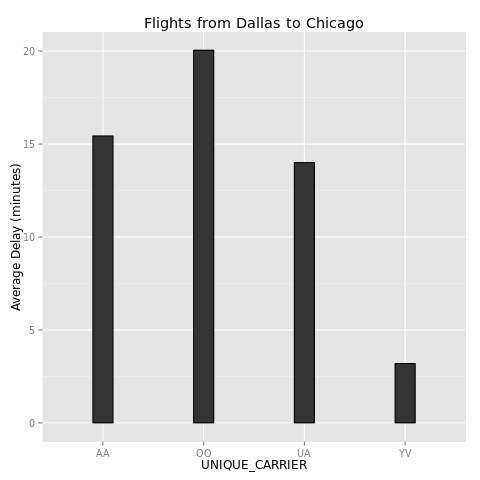

In [47]:
%%R

AirPlot('Dallas', 'Chicago', 'UNIQUE_CARRIER')

There are only four carriers that seem to offer direct flights from Dallas to Chicago in the database. Unfortunately, the dataframe has each carrier listed with a two letter code. We can look up these codes quickly from the carriersDB object we loaded at the beginning (using some regular expression magic). The ^ (caret) means look for matching patterns that start with this, whereas the dollar sign means ending. To get an exact grep match, we enclose our strings inside '^$'.

In [41]:
%%R

subset(carriersDB, grepl('^AA$|^OO$|^UA$|^YV$', Code))

     Code            Description
149    AA American Airlines Inc.
1019   OO  SkyWest Airlines Inc.
1381   UA  United Air Lines Inc.
1558   YV     Mesa Airlines Inc.


Mesa Airlines is a smaller airline, so it probably is easier for them to keep their flights on time. Looks like SkyWest is the carrier to avoid if you want to be on time!

What if we wanted to see which month is the best to fly in? Let's look at that next.

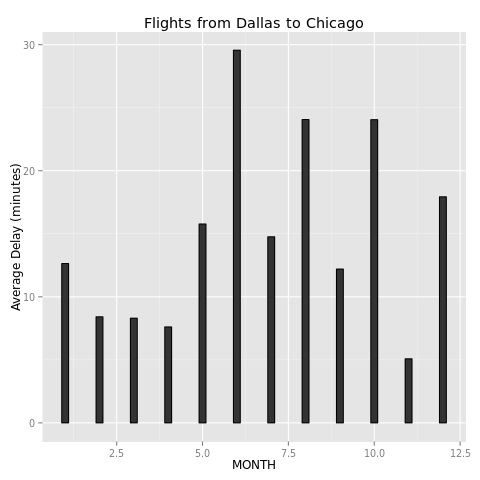

In [48]:
%%R

AirPlot('Dallas', 'Chicago', 'MONTH')

June seems to be the worst month for this route. If you combine increased summer vacation travel and thunderstorms over north Texas, this makes sense. The best month seems to be November, which is surprising a bit given Thanksgiving occurs here. Do we get the same results if the flight starts in Chicago instead? 

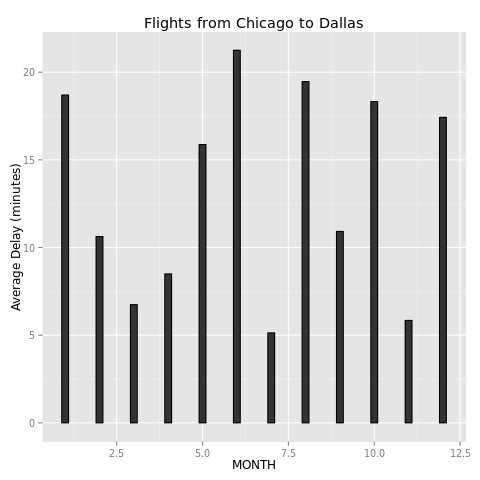

In [49]:
%%R

AirPlot('Chicago', 'Dallas', 'MONTH')

Well, June just seems to be a bad month for both cities. However, notice that winter weather is causing more of a problem in Chicago than in Dallas. 

Now that we have some information on the monthly variability, let's look at which day of the week is the best to fly. Let's try a new route, such as Boston to Atlanta.

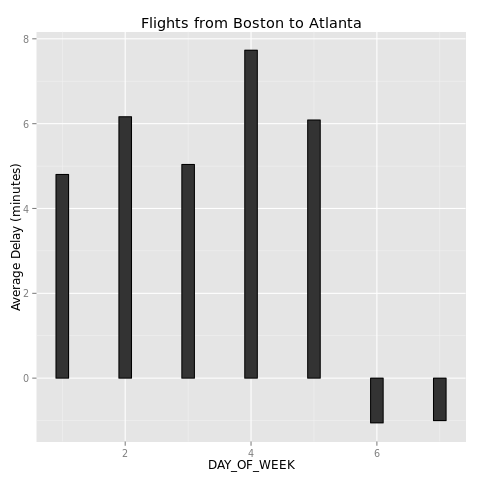

In [60]:
%%R

AirPlot('Boston', 'Atlanta', 'DAY_OF_WEEK')

Note that the day of week starts on Monday (so Monday = 1, Tuesday = 2, etc.). We can see that Saturday and Sunday are the best days to fly if you want to be on time, with Thursday having the most problems. 

Next, let's look to see if having a flight closer to a holiday causes late arrivals for our Boston to Atlanta route.

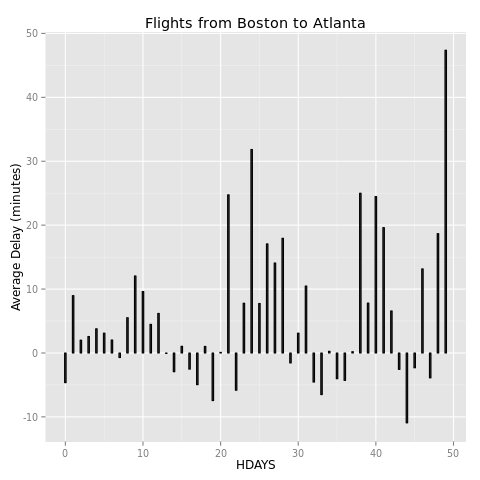

In [61]:
%%R

AirPlot('Boston', 'Atlanta', 'HDAYS')

There didn't seem to be much of a clear pattern here. It is possible this feature is a good predictor for only some flights but not others. Perhaps looking at the departure hour will give a stronger signal.

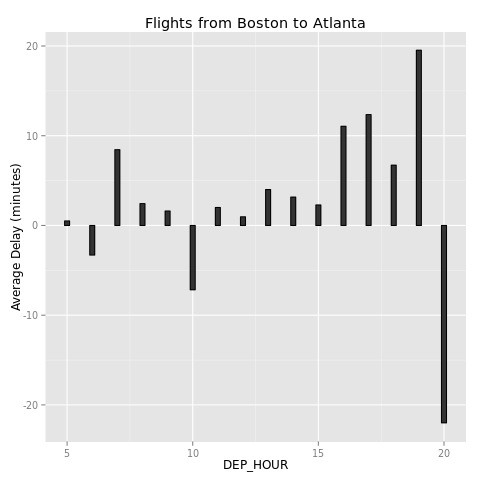

In [62]:
%%R

AirPlot('Boston', 'Atlanta', 'DEP_HOUR')

It does look like the delay increases after 4 pm departures (converting from the 16th hour). Interesting that flights leaving for Atlanta after 8 pm seemed to be very early!

Is the pattern for arrival hour about the same?

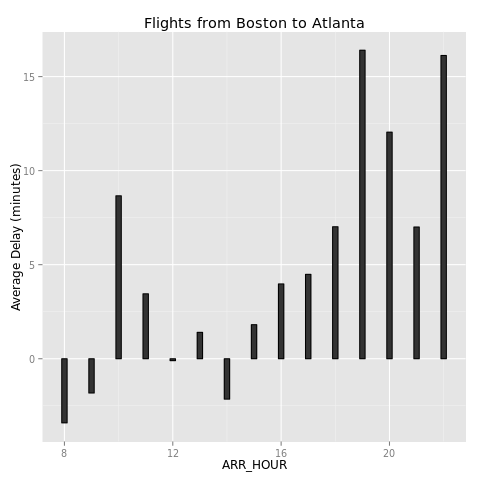

In [63]:
%%R

AirPlot('Boston', 'Atlanta', 'ARR_HOUR')

The scheduled arrival hour seems to be a better predictive feature than departure hour for this route. With a few minor exceptions, flights arrive increasingly late the further along in the day the flight is scheduled to arrive. 

Feel free if you have an interactive version to obtain the statistics for your most common flight and play around! Remember, however, that these statistics are for direct flights. For example, trying New York City to Los Angeles doesn't return any flights in the database. Most likely, the plane will be connecting somewhere, like Dallas, in between. 

Now that we have interacted with the data and explored it some, it is time to export a copy to Python before we end our time in R. To make a machine learing algorithm in scikit-learn, all of the data has to be numeric. Our short carrier abbreviation from the original data won't work. Instead, we need to transform all of the carriers into numeric levels. We can add this as a new feature to the dataframe. This is easy to do with just one line of R.

In [64]:
%%R

flightsDB$CARRIER_CODE <- as.numeric(as.factor(flightsDB$UNIQUE_CARRIER))

Let's examine the frame one last time to see if it is ready.

In [74]:
%%R

head(flightsDB)

  MONTH DAY_OF_MONTH DAY_OF_WEEK UNIQUE_CARRIER ORIGIN_AIRPORT_ID
1     1            1           3             AA             12478
2     1            2           4             AA             12478
4     1            4           6             AA             12478
5     1            5           7             AA             12478
6     1            6           1             AA             12478
7     1            7           2             AA             12478
  DEST_AIRPORT_ID CRS_DEP_TIME CRS_ARR_TIME ARR_DELAY CRS_ELAPSED_TIME DISTANCE
1           12892          900         1225        13              385     2475
2           12892          900         1225         1              385     2475
4           12892          900         1225        59              385     2475
5           12892          900         1225       110              385     2475
6           12892          900         1225        -8              385     2475
7           12892          900         1225       -13     

We will need to drop the CRS_DEP_TIME/CRS_ARR_TIME features, as these times are too precise. We can use our binned times as categorical levels instead. Then, save it to a .csv that Python can read via pandas.

In [88]:
%%R

numericDB <- select(flightsDB, -c(CRS_DEP_TIME, CRS_ARR_TIME))
write.csv(numericDB, 'FinalFlightsNumeric.csv')

We are now finished with R. In the next part of the notebook, we will create an algorithm that will predict how late (or early) our flight will be using Python. 

##Part 2: Regression Model to Predict Flight Delays

Now that we have explored the data some, let's create our regression model to predict how late a flight is going to be. First, load two datasets: the airport text file that has the codes for each of the airports and the numeric dataset we just created in R. 

__WARNING__: Make sure you have at least __4 GB__ of memory available or your computer might have some problems with this if you are interacting with the notebook. This is not a trivial number of training examples! I would also recommend restarting the kernel and running the cells in Part 2 only to free up some memory.

If you want to try following along, you could get away with randomly sampling a smaller subset of the data, but your model performance may be different given missing training examples for certain flights. 

In [1]:
import pandas as pd
airport_lookupDF = pd.read_csv('https://s3.amazonaws.com/jsw.dsprojects/AirlinePredictions/Airport_Lookup.csv', 
                               header = 0) # Airport codes
trainDF = pd.read_csv('FinalFlightsNumeric.csv', header = 0) # Data from R

Examining our imported data from R just to check everything is alright . . .

In [2]:
trainDF.head()

,Unnamed: 0,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,HDAYS,ARR_HOUR,DEP_HOUR,CARRIER_CODE
0,1,1,1,3,AA,12478,12892,13,385,2475,0,12,9,2
1,2,1,2,4,AA,12478,12892,1,385,2475,1,12,9,2
2,4,1,4,6,AA,12478,12892,59,385,2475,3,12,9,2
3,5,1,5,7,AA,12478,12892,110,385,2475,4,12,9,2
4,6,1,6,1,AA,12478,12892,-8,385,2475,5,12,9,2


We have an extra column from the DAY_OF_MONTH that R must have copied somehow. Let's drop this first column. 

In [3]:
trainDF.drop(trainDF.columns[0], axis = 1, inplace = True)

Let's also create a lookup table we will use later that includes the carrier names along with the factor levels we assigned them in R earlier.

In [4]:
carrierDF = trainDF[['UNIQUE_CARRIER', 'CARRIER_CODE']].drop_duplicates() # Only get unique examples

We can see that our airlines now have unique levels by examining our new dataframe. 

In [5]:
carrierDF.head()

,UNIQUE_CARRIER,CARRIER_CODE
0,AA,2
40359,AS,3
51793,B6,4
67462,DL,5
123313,EV,6


Because we want our training data to be entirely numerical, we should now drop the UNIQUE_CARRIER feature from trainDF.

In [6]:
trainDF.drop('UNIQUE_CARRIER', axis = 1, inplace = True)

Similar to what we did in R, let's also create our HDAYS hash table. This time it has already been calculated. We just need the unique entries in the dataframe.

In [7]:
hdaysDF = trainDF[['MONTH', 'DAY_OF_MONTH', 'HDAYS']].drop_duplicates()

Now, what kind of model would be appropriate given our large dataset?

Using a tree-based method with this large number of training examples (nearly 6 million!) would be computationally infeasible. We will also need sparse matrices for our features after one-hot encoding (which trees in scikit-learn can't use yet anyway) so we need to rely on a regression model that scales more easily and is better suited for [online learning](http://en.wikipedia.org/wiki/Online_machine_learning): ridge regression. Because of this, we will need to preprocess our data to have one-hot encoding of categorical features and feature scaling of numerical features. This is similar to what we did in the faculty salaries project. 

First, let's separate our features into categorical/numerical categories to make processing simpler.

In [8]:
scalingDF = trainDF[['DISTANCE', 'HDAYS']].astype('float') # Numerical features
categDF = trainDF[['MONTH', 'DAY_OF_MONTH', 'ORIGIN_AIRPORT_ID', 
                   'DEST_AIRPORT_ID', 'ARR_HOUR', 'DEP_HOUR', 
                   'CARRIER_CODE', 'DAY_OF_WEEK']] # Categorical features



Now do the one hot encoding for the categorical variables. We need to keep our array sparse because of how large it is (otherwise it would take up way too much memory!) 

In [9]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() # Create encoder object
categDF_encoded = encoder.fit_transform(categDF) # Can't convert this to dense array: too large!

Looking at the type of our encoded array:

In [10]:
type(categDF_encoded)

scipy.sparse.csr.csr_matrix

We can see it is a sparse array. If we are going to combine our features back together, we need to also make our numerical array sparse. Let's convert the numerical array to sparse now.

In [11]:
from scipy import sparse # Need this to create a sparse array
scalingDF_sparse = sparse.csr_matrix(scalingDF)

Now we need to combine our features together to make our feature matrix.

In [12]:
x_final = sparse.hstack((scalingDF_sparse, categDF_encoded))

Let's also get our target values, which are the delay time.

In [13]:
y_final = trainDF['ARR_DELAY'].values

Finally, we need to split into test/train samples so we can see how well our regressor is doing. 

In [14]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final,y_final,test_size = 0.2,random_state = 0) # Do 80/20 split

Now that we have split our samples into train/test, we still need to scale the numerical features. However, we must also be careful that the information used to scale the features is not the entire set: just the training set separately. Otherwise we would be "cheating" by obtaining information from the testing set that will influence the mean and standard deviation. 

First, convert our train/test data to a dense array so that we can use the StandardScaler() from scikit-learn. 

In [15]:
x_train_numerical = x_train[:, 0:2].toarray() # We only want the first two features which are the numerical ones.
x_test_numerical = x_test[:, 0:2].toarray()

Now do our scaling and convert our numerical data back to sparse after we are finished. Notice that the scaler is only fit on the training data and not the entire dataset.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # create scaler object
scaler.fit(x_train_numerical) # fit with the training data ONLY
x_train_numerical = sparse.csr_matrix(scaler.transform(x_train_numerical)) # Transform the data and convert to sparse
x_test_numerical = sparse.csr_matrix(scaler.transform(x_test_numerical))

Finally, replace the first two columns of our x_train/test sets with the new scaled values. The warning isn't important. 

In [17]:
x_train[:, 0:2] = x_train_numerical
x_test[:, 0:2] = x_test_numerical

/usr/local/lib/python2.7/dist-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now that we have our training/test sets ready, scaled, and one-hot encoded, we can start training our regression model.

##Training The Model

As mentioned earlier, we need a regression model that can scale to nearly 6 million training examples. Scikit-learn has just the model for us in this kind of situation: [the SGD (or Stochastic Gradient Descent) regressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html). It can accept sparse matrices and is recommended for greater than 10,000 training examples. 

Essentially, the model is updating the weights of a ridge regression model (if we use L2 regularization) by inputting one training example at a time instead of all of them in a single batch. This greatly reduces the amount of memory you need when running the model and works well for models that constantly need updates (such as streaming data). 

Let's try some cross-validation to see which alpha parameter is the best given the suggestions on scikit-learn. We will use GridSearch to do this for us. 

In [18]:
from sklearn.linear_model import SGDRegressor
from sklearn.grid_search import GridSearchCV
import numpy as np

SGD_params = {'alpha': 10.0**-np.arange(1,7)} # Suggested range we try
SGD_model = GridSearchCV(SGDRegressor(random_state = 0), SGD_params, scoring = 'mean_absolute_error', cv = 5) # Use 5-fold CV 
SGD_model.fit(x_train, y_train) # Fit the model

GridSearchCV(cv=5,
       estimator=SGDRegressor(alpha=0.0001, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='squared_loss',
       n_iter=5, penalty='l2', power_t=0.25, random_state=0, shuffle=False,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-01,   1.00000e-02,   1.00000e-03,   1.00000e-04,
         1.00000e-05,   1.00000e-06])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_absolute_error', verbose=0)

Now let's see how it does on our test set. 

In [19]:
from sklearn.metrics import mean_absolute_error

y_true, y_pred = y_test, SGD_model.predict(x_test) # Predict on our test set

print 'Mean absolute error of SGD regression was:'
print(mean_absolute_error(y_true, y_pred))

Mean absolute error of SGD regression was:
21.4465811351


Well, a mean absolute error of 21 minutes isn't wonderful performance, but it may be the best we can do given the limitations of our data. There are ways this error could be improved (training separate models for each different route perhaps?) or including even more data from other years may help.  A lot of the delays depend on factors outside of our feature set (such as weather) that our model may not be picking up on well enough, and adding these as features could be beneficial (if they won't cause a data leak, which can be difficult).

However, it at least will allow us to get a rough idea of how late our flight will be. Let's start implementing this model so we can use it to predict a flight's delay. 

##Function Implementation

Now that we have our regression model trained and ready, it's time to design a function that utilizes it. 

The function will allow the user to enter all of the information about their flight and return the predicted delay time in minutes. The inputs will be:

- Origin Airport
- Destination Airport
- Carrier
- Scheduled Departure Hour
- Scheduled Arrival Hour
- Month
- Day
- Day of Week

None of these inputs are data leakage, as the user will know this information well in advance of their flight. That way, the regression model can be used at any point in time. 

First, similar to the R program in the first part of the notebook, we will need a function that can automatically find the airport codes for our origin and destination airports. The function will take the codes found in our feature set corresponding to a particular city and calculate which airport has the largest number of flights. Let's create that first.

In [20]:
def max_num_flights(codes):
    '''
    This is a function for the delay prediction function to use for calculating the number of 
    flights in the database for a given city.
    
    Inputs: list of codes retrived in the delay_prediction function
    Output: The code with the largest number of flights.
    '''
    num_store = np.zeros(len(codes)) # Store all possible airport codes
    
    if len(codes) < 1:
        print('Try entering your city/airport again. No matching airports found.') # In case the aiport didn't show up 
        return                                                                     # in the data
    
    for i in xrange(len(codes)):
        num_flights = trainDF.MONTH[trainDF.ORIGIN_AIRPORT_ID == codes[i]].count() # Count number of rows in data for each
        num_store[i] = num_flights                                                 # airport code
       
    
    # Now find the maximum row
    
    max_ind = int(np.where(num_store == max(num_store))[0])
    # Now we know which code had the most flights. Return it.
    return(codes[max_ind])

Finally, we can make our prediction function. It will need to transform the function inputs into a feature vector that our trained SGD regressor model can predict with. That means all of the inputs will need to have feature scaling and one-hot encoding applied to them as well so that the model works correctly. 

In [27]:
def delay_prediction(origin = 'Fort Worth', destination = 'Chicago', carrier = 'American', 
                      dept_time = 17, arr_time = 19, month = 5, day = 15, weekday = 'Wednesday'):
                      
    '''
    This function allows you to input all of your flight information (no leaks!) and
    the function will return how late your flight will arrive based on the output from the 
    SGD Regressor.
     
    Inputs: 
     
         Origin (enter this as a city, state combo, or include the airport name (such as Bush
                     or Hobby). This will automatically calculate which airport you meant.
             
         Destination (same as Origin, entered as a string)
             
         Carrier (which Airline, use a string to represent the name (such as 'American' or 'United')
             
         Departing Hour scheduled (just the hour of departure, based on a 24 hour cycle. This means
                             noon would be 12, and midnight would be 0.)
             
         Arriving Hour scheduled (same format as departing)
             
         Month (the month the flight is scheduled for)
             
         Day (the day of the month the flight is scheduled for)
             
         Weekday (Enter as a capitalized word, such as 'Monday')
             
         Available Carriers:
            AirTran
            Alaska
            American
            Delta
            Endeavor
            Envoy
            ExpressJet
            Frontier
            Hawaiian
            JetBlue
            Mesa
            SkyWest
            Southwest
            United
            US Airways
            Virgin
            
     Outputs: Estimated delay for the arrival (in minutes, can be negative if the flight is expected to arrive early)
     '''
     
    # Create a dict for our Airlines. Based on the carrierDF.
     
    carrier_dict = {'Endeavor':1, 'American':2, 'Alaska':3, 'JetBlue':4, 'Delta':5,
                     'ExpressJet':6, 'Frontier':7, 'AirTran':8, 'Hawaiian':9, 'Envoy':10,
                     'SkyWest':11, 'United':12, 'US Airways':13, 'Virgin':14,
                     'Southwest':15, 'Mesa':16}
                     
    # Another for day of the week
     
    weekday_dict = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,
                     'Friday':5, 'Saturday':6, 'Sunday':7}
                     
    # Now find the corresponding airport codes for our origin and destination. 
     
    origin_codes = list(airport_lookupDF[airport_lookupDF.Description.str.contains(origin)].Code)
    destination_codes = list(airport_lookupDF[airport_lookupDF.Description.str.contains(destination)].Code)
     
    # From these codes found in the lookup table, see which one had the largest number of flights.
                                                                                                                                                                                                                                                                                                                                     
    origin_code = max_num_flights(origin_codes)
    destination_code = max_num_flights(destination_codes)
     
    # Now that we have these codes, we can look up the other parameters necessary.
     
    # Start with looking up HDAYS.
     
    hdays = np.array(float(hdaysDF[(hdaysDF.MONTH == month) & (hdaysDF.DAY_OF_MONTH == day)].HDAYS))
     
    # Now find the distance between the two airports. Add a try/except to catch any problems.
   
    try:
        distance = np.array(float(trainDF[(trainDF.ORIGIN_AIRPORT_ID == origin_code) & 
                              (trainDF.DEST_AIRPORT_ID == destination_code)].DISTANCE.drop_duplicates()))
    except:
        print 'Route was not found in the data. Please try a different nearby city or a new route.'
        return
     
    carrier_num = carrier_dict[carrier]
    weekday_num = weekday_dict[weekday]
     
    # Now that we have all of our values, we can start combining them together.
     
    # First, create our numeric array of distance and hdays.
     
    numerical_values = np.c_[distance, hdays]
     
    # Scale the features
     
    numerical_values_scaled = scaler.transform(numerical_values)
     
    # Now create our array of categorical values.
     
    categorical_values = np.zeros(8)
    categorical_values[0] = int(month)
    categorical_values[1] = int(day)
    categorical_values[2] = int(origin_code)
    categorical_values[3] = int(destination_code)
    categorical_values[4] = int(arr_time)
    categorical_values[5] = int(dept_time)
    categorical_values[6] = int(carrier_num)
    categorical_values[7] = int(weekday_num)
     
    # Apply the one-hot encoding to these.
     
    categorical_values_encoded = encoder.transform([categorical_values]).toarray()
     
    # Combine these into the final test example that goes into the model
     
    final_test_example = np.c_[numerical_values_scaled, categorical_values_encoded]
     
    # Now predict this with the model 
     
    pred_delay = SGD_model.predict(final_test_example)
    print 'Your predicted delay is', int(pred_delay[0]), 'minutes.'
    return # End of function
     

Now that we have our function, let's try it out!

Suppose we wanted to take a Spring Break trip from Washington, DC to Miami on United and were curious as to whether our flight was likely going to be delayed. What does our model predict will happen?

In [24]:
delay_prediction(origin = 'Washington, DC', destination = 'Miami, FL', 
                  carrier = 'United', dept_time = 17, arr_time = 21,
                  month = 3, day = 19, weekday = 'Thursday')

Your predicted delay is 5 minutes.


That looks like it will be close to on time! 

What if, however, we are traveling in the winter from Chicago to Dallas? A delay may be more likely.

In [25]:
delay_prediction(origin = 'Dallas', destination = 'Chicago', 
                  carrier = 'American', dept_time = 17, arr_time = 20,
                  month = 1, day = 28, weekday = 'Wednesday')

Your predicted delay is 23 minutes.


What if we decided to take an earlier flight to cut down the delay time a bit. Does that work?

In [29]:
delay_prediction(origin = 'Dallas', destination = 'Chicago', 
                  carrier = 'American', dept_time = 10, arr_time = 13,
                  month = 1, day = 28, weekday = 'Wednesday')

Your predicted delay is 16 minutes.


It did seem to help some, yes! 

##Ideas for Improvement and Summary

In this notebook, we took data from the Department of Transportation regarding flight on-time performance. We did some feature engineering and made functions in R that allowed us to easily explore the data. Then, we prepared our data for a SGD Regressor model via feature scaling/one-hot encoding and made a function that could predict how late our flight was going to be. This project was a bit more difficult than the faculty salary project because the dataset was much larger, so we had to consider model solutions that would be computationally feasible. 

Possible ideas for improvement:

- Allow integration of weather forecast data into the model but only if the user was a few days away from the flight's departure

- Try creating separate models for each flight path to see if that improves the accuracy of our prediction

- Make the delay_prediction function more robust with fewer potential bugs. There are certain edge cases that could cause issues, such as an airline input into the function not being at the airport in question (Southwest, for example, tends to fly at smaller airports only)

- The HDAYS variable will need to be updated for each year used, as some holidays are not on the same date every year. In the program's current form, it only looks at holidays for the date range we originally downloaded the data from